In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [8]:
import random
import numpy as np
import pandas as pd

In [9]:
import plotting
from dataset import Dataset

## Разбор

### Выгрузим многомерный ряд

In [10]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

<Axes: xlabel='timestamp'>

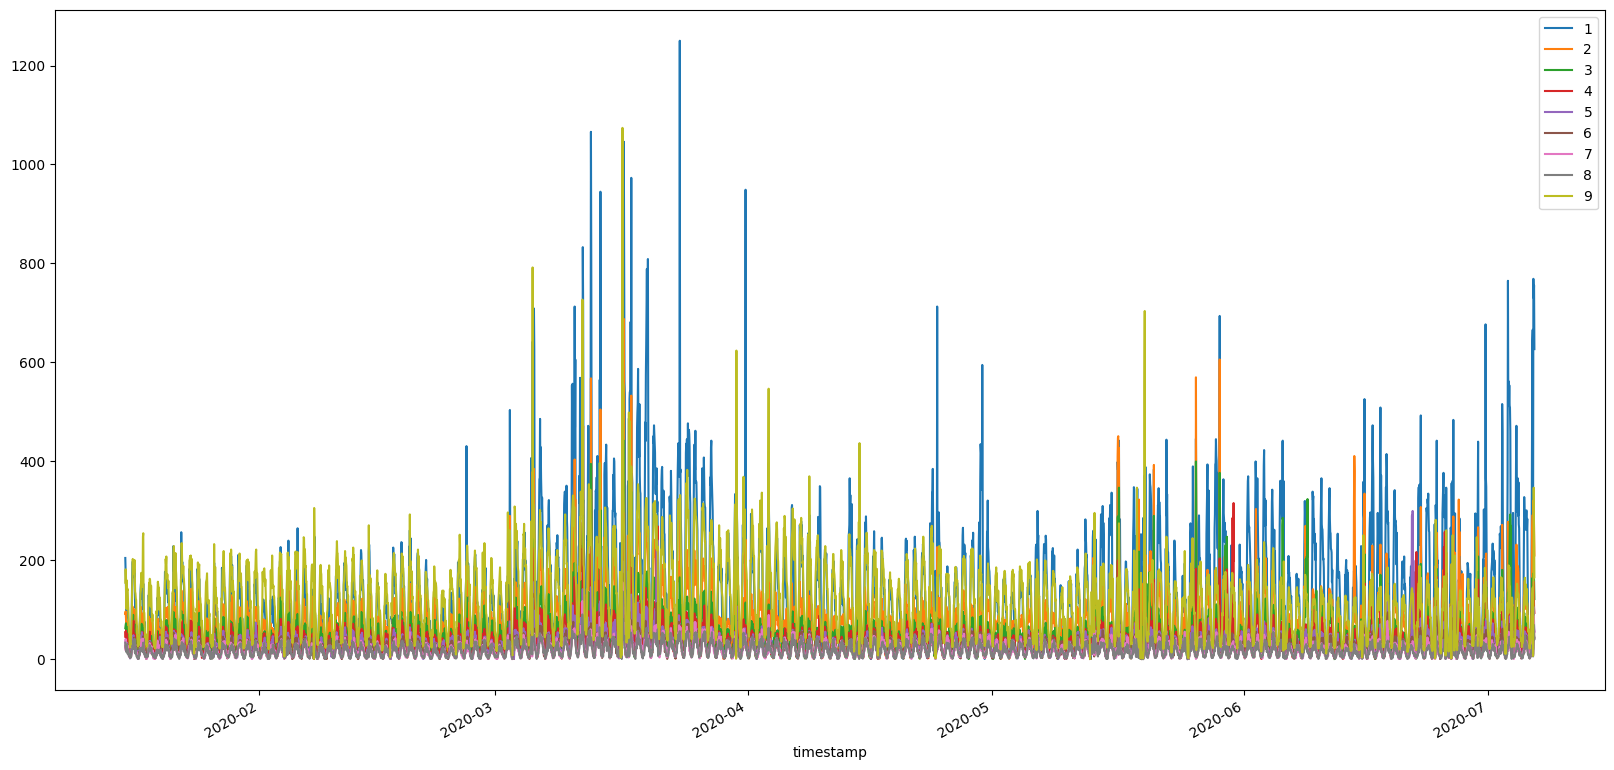

In [11]:
ts.plot(figsize=(20, 10))

### Приведем все значения к относительному виду

In [13]:
from stability_index import to_relative

In [14]:
norm_ts = to_relative(ts)

In [15]:
norm_ts.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,0.302806,0.135894,0.093058,0.081241,0.038405,0.039882,0.029542,0.050222,0.228951
2020-01-15 14:00:00,0.252555,0.141606,0.100730,0.064234,0.045255,0.032117,0.059854,0.037956,0.265693
2020-01-15 15:00:00,0.226209,0.129485,0.113885,0.090484,0.062402,0.039002,0.048362,0.029641,0.260530
2020-01-15 16:00:00,0.193103,0.137931,0.121839,0.089655,0.073563,0.071264,0.043678,0.034483,0.234483
2020-01-15 17:00:00,0.208929,0.137500,0.071429,0.094643,0.058929,0.051786,0.037500,0.053571,0.285714


### Посчитаем дневной и часовой stability index для последней точки

![img](../data/images/si.png)

In [16]:
from stability_index import calculate_ts_stability_index

In [17]:
calculate_ts_stability_index(
    norm_ts[:-1], norm_ts.iloc[[-1]],
    reference_type='day',
    granularity='PT1H',
    fill_val=0.5
)

0.04719051696106927

In [18]:
calculate_ts_stability_index(
    norm_ts[:-1], norm_ts.iloc[[-1]],
    reference_type='instant',
    granularity='PT1H',
    fill_val=0.5
)

0.010093424689737085

### Посчтитаем stability index для всех точек временного ряда

In [19]:
from stability_index import calculate_ts_stability_index_batch

In [20]:
si_day = calculate_ts_stability_index_batch(norm_ts)

In [21]:
si_day.tail()

2020-07-06 12:00:00    0.538301
2020-07-06 13:00:00    0.278769
2020-07-06 14:00:00    0.020073
2020-07-06 15:00:00    0.041673
2020-07-06 16:00:00    0.047191
dtype: float64

In [22]:
si_hour = calculate_ts_stability_index_batch(norm_ts, reference_type='instant')

In [23]:
si_hour.tail()

2020-07-06 12:00:00    0.190018
2020-07-06 13:00:00    0.110627
2020-07-06 14:00:00    0.202086
2020-07-06 15:00:00    0.035574
2020-07-06 16:00:00    0.010093
dtype: float64

In [24]:
plotting.plot_ts(si_day, si_hour)

Loading BokehJS ...

<Axes: >

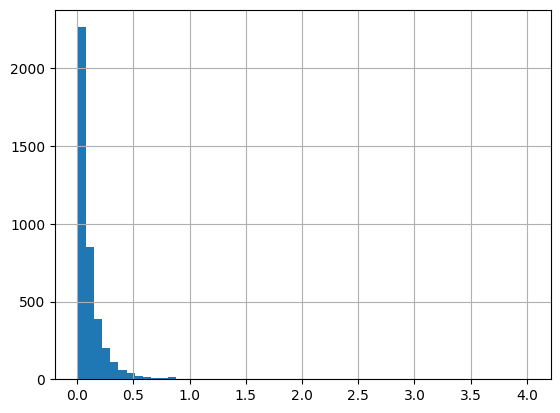

In [26]:
si_day.hist(bins=55)

<Axes: >

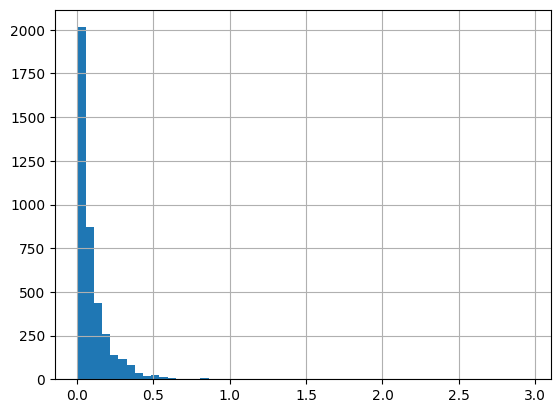

In [27]:
si_hour.hist(bins=55)

### Введем порог 0.5

In [28]:
T = 0.5

In [29]:
day_anoms = si_day[si_day > T]

In [30]:
day_anoms.head(3)

2020-01-24 00:00:00    0.557815
2020-02-21 02:00:00    0.546983
2020-02-26 04:00:00    0.569483
dtype: float64

In [31]:
hour_anoms = si_hour[si_hour > T]

In [32]:
hour_anoms.head(3)

2020-02-06 05:00:00    0.575016
2020-02-18 03:00:00    0.534437
2020-02-21 03:00:00    0.800673
dtype: float64

In [33]:
plotting.plot_ts(si_day, si_hour, pd.Series([T]*len(si_day), index=si_day.index))

Loading BokehJS ...

## Практика

#### 1. Реализуйте функцию to_relative, возвращающую относительные значения ряда для каждой точки y_i(t) / sum(y(t))

In [35]:
def to_relative(multi_ts: pd.DataFrame):
    """
    Transforms multi-dimensional time series into relative values
    """
    # <your code here>

#### 2. Реализуйте расчет stability index для двух распределений

In [36]:
def calculate_si(real: np.array, reference: np.array):
    """
    Calculates population stability index using following formula
    SI = Σ (pA i - pB i ) * ( ln(pA i ) - ln(pB i ) )

    Parameters
    ----------
    real : 1d np.array
        Distribution for
    reference : 1d np.array
        Reference distribution.

    Returns
    -------
    stability_index : float
    """
    # <your code here>

#### 3. Реализуйте функцию calculate_ts_stability_index для одной точки временного ряда

In [37]:
import isodate
from datetime import timedelta

def _get_reference_time_delta(reference_type, granularity):
    """Gets timedelta for one of the following reference types: {'day', 'hour', 'instant'}"""
    if reference_type == 'day':
        delta = timedelta(days=1)
    elif reference_type == 'hour':
        delta = timedelta(hours=1)
    else:
        delta = isodate.parse_duration(granularity)
    return delta

In [38]:
def calculate_ts_stability_index(
    ts: pd.DataFrame,
    incoming_point: pd.DataFrame,
    reference_type='day',
    granularity='PT1H',
    fill_val=0.5
):
    """
    Calculates population stability index for n-dimensional time-series.

    Parameters
    ----------
    ts : pd.Dataframe (n_samples, n_dim) with datetime index
        N-dimensional time-series with granularity of the iso-8601
    incoming_point : pd.Dataframe of shape (1, 9) with datetime index
        New point, for which to make decision about stability.
    reference_type : {'instant', 'day', 'week'}
        Point which distribution gets compared to the incoming point.
        'instant' stand for previous point, 'day' for point 24 hours ago and
        'week' stands for 24*7 hours ago.
    granularity: str
        Frequency of time-series
    fill_val : float
        Value to fillna

    Returns
    -------
    si : float
        Stability index for incoming point calculated relative to reference point.
    """
    
    # ваш код здесь

#### 4. Реализуйте функцию, проходящую по всем точкам ряда и считающую для каждой точки stability_index

In [39]:
def calculate_ts_stability_index_batch(ts, **kwargs):
    """Returns series with stability index calculated for every point of ts, where possible"""
    # ваш код здесь

#### 5. Реализуйте динамический порог для stability index при помощи класса TimeSeriesPredictor из прошлого занятия.
* получите временной ряд stability index при помощи calculate_ts_stability_index_batch
* обучите модель TimeSeriesPredictor
* для каждой точки из истории, где возможно:  
        а) выдайте для нее предсказание обученной моделью
        б) получите верхний доверительный интервал
        в) посчитайте текущий stability index
        г) выдайте вердикт об аномальности, сравнив с доверительным интервалом

#### 6. Сделайте предсказание для суммы всех бакетов как одномерного ряда и получите список аномалий. Какая область пересечения аномалий у данного подхода и stability index? Обьясните разницу.